In [86]:
import pandas as pd
import matplotlib.pyplot as plt

Top 100 Ether balances obtained from Ethereum public datasets (the corresponding table contains Ether balances of all addresses, updated daily) on Google Cloud using BigQuery:
``` mysql
SELECT *
FROM `bigquery-public-data.crypto_ethereum.balances`
WHERE eth_balance > 0
ORDER BY eth_balance DESC 
LIMIT 100
```

In [87]:
bq_eth_df = pd.read_json('daily_top_100_eth_balances_[25 Oct 2021, 13:49:26 UTC+1]_results-20211026-090241.json')
bq_eth_df.rename(columns={'eth_balance': 'balance'}, inplace=True)
bq_eth_df['balance'] /= 10**18  # convert Wei to Ether
bq_eth_df

,address,balance
0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,8.139444e+06
1,0x00000000219ab540356cbb839cbe05303d7705fa,8.011266e+06
2,0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,2.296896e+06
3,0x73bceb1cd57c711feac4224d062b0f6ff338501e,1.874773e+06
4,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,1.499808e+06
...,...,...
95,0xd05e6bf1a00b5b4c9df909309f19e29af792422b,1.500000e+05
96,0x2fa9f9efc767650aace0422668444c3ff63e1f8d,1.485317e+05
97,0xd57479b8287666b44978255f1677e412d454d4f0,1.476994e+05
98,0xc6dcb7ac175636cbc3d5f32c68865c24ca7d74d4,1.461931e+05


The following is obtained from [Etherscan.io](https://etherscan.io/accounts):

In [88]:
etherscan_df = pd.read_csv('etherscan_top_100_balances_[2021-10-26 10:56:12 IST].csv', header=0)
etherscan_df

,address,balance
0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,8.175899e+06
1,0x00000000219ab540356cbb839cbe05303d7705fa,8.018114e+06
2,0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,2.296896e+06
3,0x73bceb1cd57c711feac4224d062b0f6ff338501e,1.874773e+06
4,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,1.485087e+06
...,...,...
95,0x2fa9f9efc767650aace0422668444c3ff63e1f8d,1.485317e+05
96,0xd57479b8287666b44978255f1677e412d454d4f0,1.476994e+05
97,0xc6dcb7ac175636cbc3d5f32c68865c24ca7d74d4,1.461931e+05
98,0x4baf012726cb5ec7dda57bc2770798a38100c44d,1.450001e+05


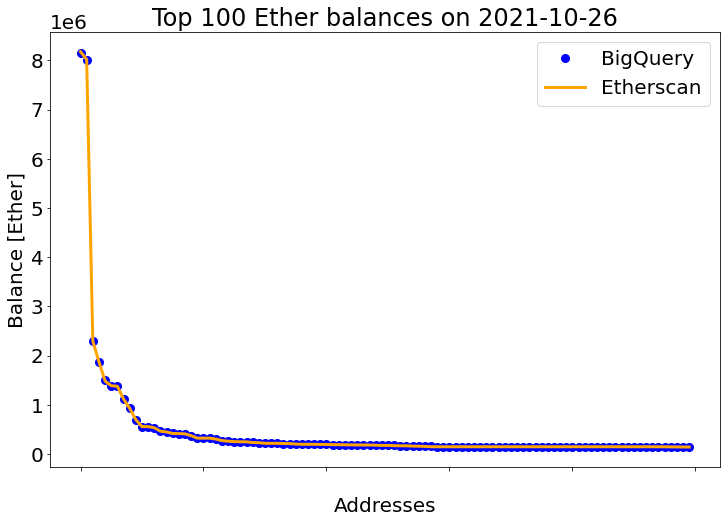

In [89]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12, 8))
plt.title('Top 100 Ether balances on 2021-10-26')
plt.xlabel('Addresses')
plt.ylabel('Balance [Ether]')
plt.xticks(color='w')
plt.plot(bq_eth_df['balance'], marker='o', markersize='8', color='blue', linestyle='', label='BigQuery')
plt.plot(etherscan_df['balance'], linestyle='-', linewidth=3, color='orange', label='Etherscan')
plt.legend()
plt.show()

To get top Ether balances for a given date (e.g. 2018-11-12), the following query shall be used (see [awesome-bigquery-views](https://github.com/blockchain-etl/awesome-bigquery-views#top-ethereum-balances) for details):
``` mysql
#standardSQL
with double_entry_book as (
    -- debits
    select to_address as address, value as value
    from `bigquery-public-data.crypto_ethereum.traces`
    where to_address is not null
    and status = 1
    and value > 0
    and date(block_timestamp) < "2018-11-13"
    and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)
    union all -- combines results from different 'selects' with duplicates
    -- credits
    select from_address as address, -value as value
    from `bigquery-public-data.crypto_ethereum.traces`
    where from_address is not null
    and status = 1
    and value > 0
    and date(block_timestamp) < "2018-11-13"
    and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)
    union all
    -- transaction fees debits
    -- select miner as address, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value
    select miner as address, sum(cast(receipt_gas_used as numeric) * cast((receipt_effective_gas_price - coalesce(base_fee_per_gas, 0)) as numeric)) as value
    from `bigquery-public-data.crypto_ethereum.transactions` as transactions
    join `bigquery-public-data.crypto_ethereum.blocks` as blocks on blocks.number = transactions.block_number
    group by blocks.miner
    union all
    -- transaction fees credits
    select from_address as address, -(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value
    from `bigquery-public-data.crypto_ethereum.transactions`
)
select address, sum(value) as balance
from double_entry_book
group by address
order by balance desc
limit 100
```
The resultts for this query are as follows:

In [90]:
bq_eth_df = pd.read_json('top_100_eth_balances_[2018-11-12]_results-20211026-103524.json')
bq_eth_df['balance'] /= 10**18  # convert Wei to Ether
bq_eth_df

,address,balance
0,0x742d35cc6634c0532925a3b844bc454e4438f44e,1.653529e+06
1,0x281055afc982d96fab65b3a49cac8b878184cb16,1.538423e+06
2,0x6f46cf5569aefa1acc1009290c8e043747172d89,1.510066e+06
3,0x90e63c3d53e0ea496845b7a03ec7548b70014a91,1.507810e+06
4,0x53d284357ec70ce289d6d64134dfac8e511c8a3d,1.378754e+06
...,...,...
95,0x47029dc4f3922706bf670d335c45550cff4f6a35,1.228616e+05
96,0xddf744374b46aa980ddce4a5aa216478bf925cd1,1.218604e+05
97,0xd224ca0c819e8e97ba0136b3b95ceff503b79f53,1.149793e+05
98,0x376c3e5547c68bc26240d8dcc6729fff665a4448,1.149390e+05


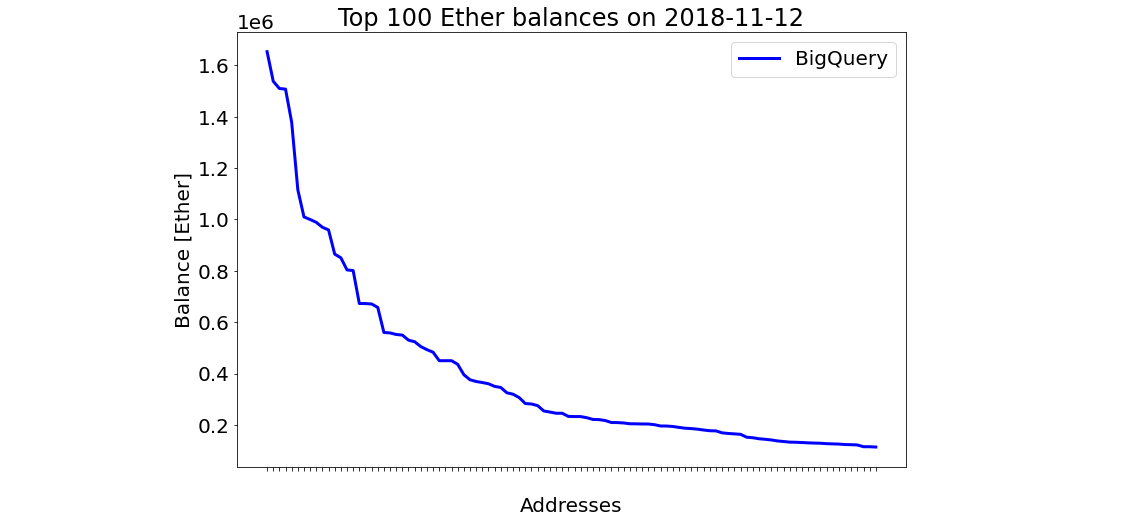

In [91]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12, 8))
plt.title('Top 100 Ether balances on 2018-11-12')
plt.xlabel('Addresses')
plt.ylabel('Balance [Ether]')
plt.xticks(color='w')
plt.plot(bq_eth_df['address'], bq_eth_df['balance'], color='blue', linestyle='-', linewidth=3, label='BigQuery')
plt.legend()
plt.show()

To get top Bitcoin balances, we can use (see [awesome-bigquery-views](https://github.com/blockchain-etl/awesome-bigquery-views#top-bitcoin-balances) for details):
``` mysql
WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   -- WHERE DATE(inputs.block_timestamp) < "2018-11-13"
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
   -- WHERE DATE(outputs.block_timestamp) < "2018-11-13"
)
SELECT address, type, sum(value) as balance
FROM double_entry_book
GROUP BY address, type
ORDER BY balance DESC
LIMIT 100
```
which gave the following results

In [92]:
bq_btc_df = pd.read_json('daily_top_100_btc_balances_[25 Oct 2021, 13:36:04 UTC+1 ]_results-20211026-104433.json')
bq_btc_df['balance'] /= 10**8  # convert Satoshi to BTC
bq_btc_df

,address,type,balance
0,34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo,scripthash,288126.209985
1,bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24...,witness_v0_scripthash,178010.985449
2,1P5ZEDWTKTFGxQjZphgWPQUpe554WKDfHQ,pubkeyhash,106354.574363
3,37XuVSEpWW4trkfmvWzegTHQt7BdktSKUs,scripthash,94505.114067
4,38UmuUqPCrFmQo4khkomQwZ4VbY2nZMJ67,scripthash,93566.021928
...,...,...,...
95,bc1qyr9dsfyst3epqycghpxshfmgy8qfzadfhp8suk,witness_v0_keyhash,9900.451786
96,bc1q8qg2eazryu9as20k3hveuvz43thp200g7nw7qy,witness_v0_keyhash,9900.098341
97,bc1q4ffskt6879l4ewffrrflpykvphshl9la4q037h,witness_v0_keyhash,9895.369770
98,bc1qa56lzf7d05ttur003zmuzwrgl3x0qau5zm2qzn,witness_v0_keyhash,9887.714116


The following is obtained from [BTC.com](https://btc.com/stats/rich-list):

In [93]:
btc_df = pd.read_csv('BTCcom_top_100_balances_[2021-10-26 12:07:14 IST].csv', header=0)
btc_df

,address,balance
0,34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo,293427.057899
1,bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8...,166510.985836
2,35hK24tcLEWcgNA4JxpvbkNkoAcDGqQPsP,115451.667857
3,1P5ZEDWTKTFGxQjZphgWPQUpe554WKDfHQ,112155.617716
4,37XuVSEpWW4trkfmvWzegTHQt7BdktSKUs,94505.831979
...,...,...
95,bc1qh4cpaydaqlzez8ekkasm3ygj4us7gwx...,9111.905706
96,17CzhFvGwH6TT46JtzhnhMpTw4mHYpEGCR,9107.364474
97,bc1q78wmm8xnhveklsparpeq6drlg9wlq4l...,9098.999109
98,1Cr7EjvS8C7gfarREHCvFhd9gT3r46pfLb,9049.832927


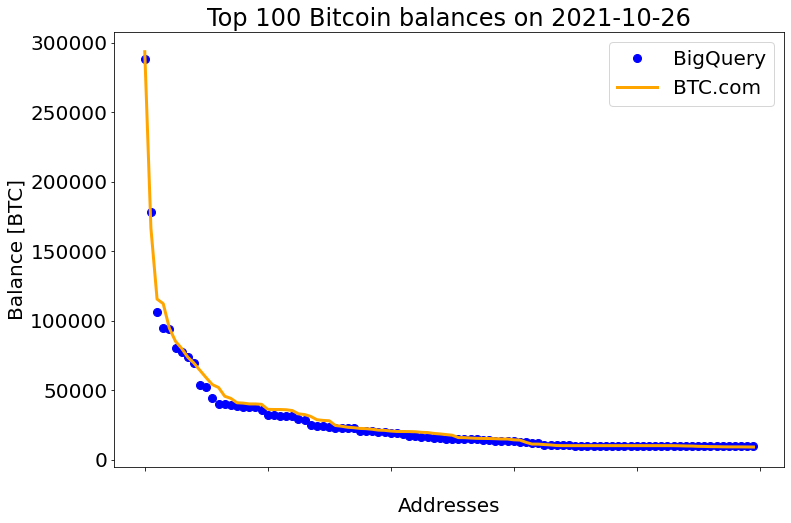

In [94]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12, 8))
plt.title('Top 100 Bitcoin balances on 2021-10-26')
plt.xlabel('Addresses')
plt.ylabel('Balance [BTC]')
plt.xticks(color='w')
plt.plot(bq_btc_df['balance'], marker='o', markersize='8', color='blue', linestyle='', label='BigQuery')
plt.plot(btc_df['balance'], linestyle='-', linewidth=3, color='orange', label='BTC.com')
plt.legend()
plt.show()